In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [4]:
df=pd.read_csv('m2_s2_bank_fd9e1495674488429597135792319d60__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==1].reset_index(drop=True)
df=df['ResistValue']
df

0      0.444
1      0.441
2      0.437
3      0.436
4      0.436
       ...  
649    0.384
650    0.385
651    0.382
652    0.388
653    0.389
Name: ResistValue, Length: 654, dtype: float64

In [54]:
def error_rate(original, prediction, ft_len, forecast_len):
    error_avg = []
    ft_len = ft_len-1
    for i in range(forecast_len):
      error = abs((original[ft_len+i] - prediction[-forecast_len+i]))/original[ft_len+i] * 100
      print('num',i,error,'actual',original[ft_len+i],'prediction',predictions[-forecast_len+i])
      print("오차율 :",error)
      error_avg.append(error)
    print('최소 오류값 :',min(error_avg))
    print('최대 오류값 :',max(error_avg))
    return sum(error_avg)/len(error_avg)

In [6]:

def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P
# Initialization for system model.
A = 1
H = 1
Q = 0.0001
R = 0.001
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [7]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - (window_size+20)):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size+window_size-1]))
    return np.array(feature_list), np.array(label_list)

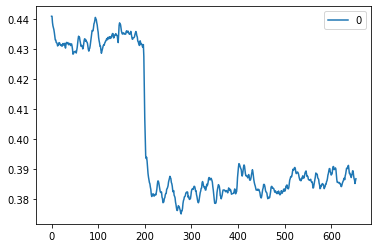

In [8]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save
tt=pd.DataFrame(df)
tt.plot()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

In [10]:
train=df_scaled
feature_cols = ['ResistValue']
label_cols = ['ResistValue']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]



In [11]:
train_feature, train_label = make_dataset(train_feature, train_label, 20)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [12]:
model= Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), 
               activation='relu'))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop=EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, epochs=100, batch_size=1)
model.save('testmodel.h5')

Epoch 1/100
491/491 [==============================] - 22s 4ms/step - loss: 0.0372 - mse: 0.0372
Epoch 2/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0158 - mse: 0.0158
Epoch 3/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0305 - mse: 0.0305
Epoch 4/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0282 - mse: 0.0282
Epoch 5/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0262 - mse: 0.0262
Epoch 6/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0223 - mse: 0.0223
Epoch 7/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0234 - mse: 0.0234
Epoch 8/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0259 - mse: 0.0259
Epoch 9/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0238 - mse: 0.0238
Epoch 10/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0280 - mse: 0.0280
Epoch 11/100
491/491 [================

# TESTING

num 0 [0.32375531] actual [0.40965048] prediction [0.4083242]
오차율 : [0.32375531]
num 1 [2.25708017] actual [0.4097449] prediction [0.40049663]
오차율 : [2.25708017]
num 2 [1.96398686] actual [0.40900335] prediction [0.40097058]
오차율 : [1.96398686]
num 3 [1.07892552] actual [0.40765166] prediction [0.4032534]
오차율 : [1.07892552]
num 4 [0.28089546] actual [0.40747561] prediction [0.40633103]
오차율 : [0.28089546]
num 5 [0.15157952] actual [0.40734712] prediction [0.40672967]
오차율 : [0.15157952]
num 6 [0.42846053] actual [0.4075235] prediction [0.40577742]
오차율 : [0.42846053]
num 7 [0.11577303] actual [0.40765223] prediction [0.40718028]
오차율 : [0.11577303]
num 8 [0.78187979] actual [0.40693571] prediction [0.40375397]
오차율 : [0.78187979]
num 9 [0.69619648] actual [0.40587246] prediction [0.4030468]
오차율 : [0.69619648]
num 10 [0.41560606] actual [0.40644723] prediction [0.404758]
오차율 : [0.41560606]
num 11 [0.34250427] actual [0.40497562] prediction [0.40636268]
오차율 : [0.34250427]
num 12 [0.12631984] a

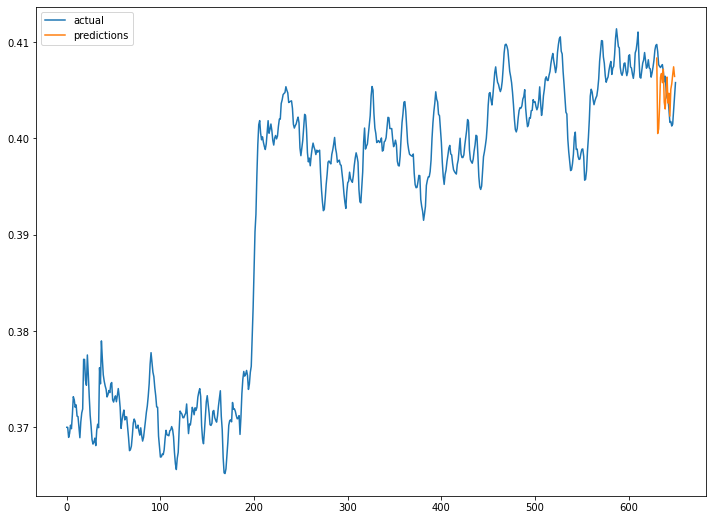

In [55]:
df=pd.read_csv('m2_s2_bank_fd9e1495674488429597135792319d60__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==23].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]
P_0=6
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save
scaler = MinMaxScaler()
scale_cols=['ResistValue']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)

# Predict
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20
x_data = range(feature_len)
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()


        

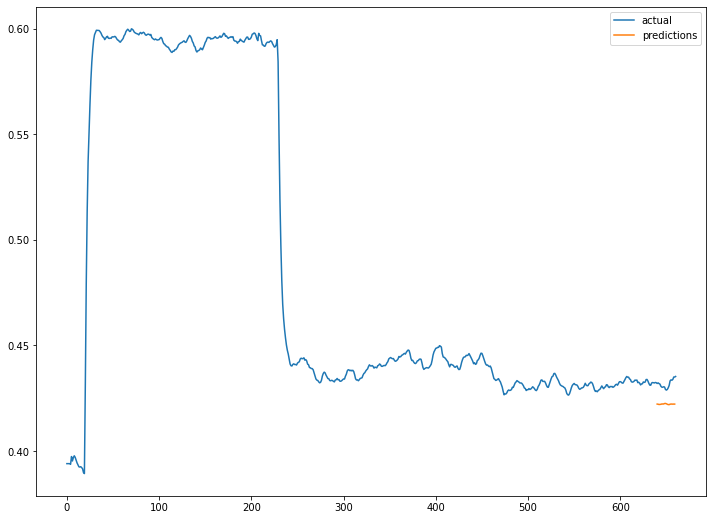

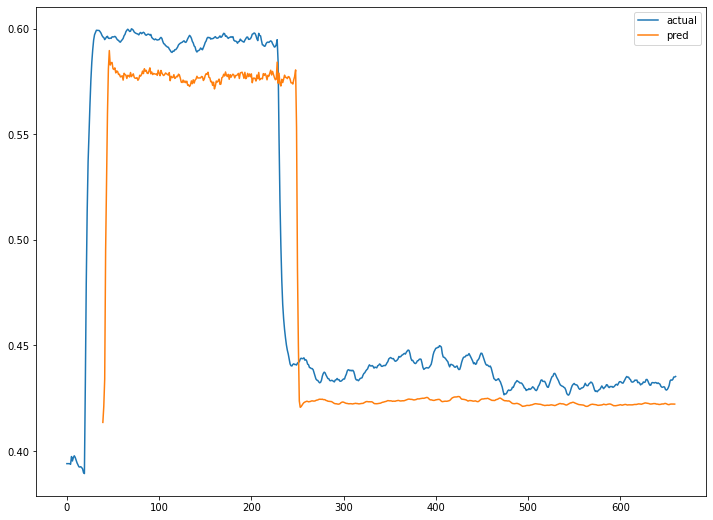

num 0 [2.43762836] actual [0.43274767] prediction [0.4221989]
오차율 : [2.43762836]
num 1 [2.46601517] actual [0.43281584] prediction [0.42214254]
오차율 : [2.46601517]
num 2 [2.45158809] actual [0.43259544] prediction [0.42198998]
오차율 : [2.45158809]
num 3 [2.33896188] actual [0.43216442] prediction [0.42205626]
오차율 : [2.33896188]
num 4 [2.3204814] actual [0.43212] prediction [0.42209274]
오차율 : [2.3204814]
num 5 [2.45980884] actual [0.43289805] prediction [0.4222496]
오차율 : [2.45980884]
num 6 [2.65093676] actual [0.43373606] prediction [0.422238]
오차율 : [2.65093676]
num 7 [2.84626262] actual [0.43461783] prediction [0.42224747]
오차율 : [2.84626262]
num 8 [2.94132325] actual [0.43526139] prediction [0.42245895]
오차율 : [2.94132325]
num 9 [2.85640121] actual [0.43492062] prediction [0.42249754]
오차율 : [2.85640121]
num 10 [2.8959239] actual [0.43494206] prediction [0.42234647]
오차율 : [2.8959239]
num 11 [2.77032778] actual [0.43414725] prediction [0.42211995]
오차율 : [2.77032778]
num 12 [2.73905371] actua

In [57]:
df=pd.read_csv('m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
df=df[df['CellNo']==4].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

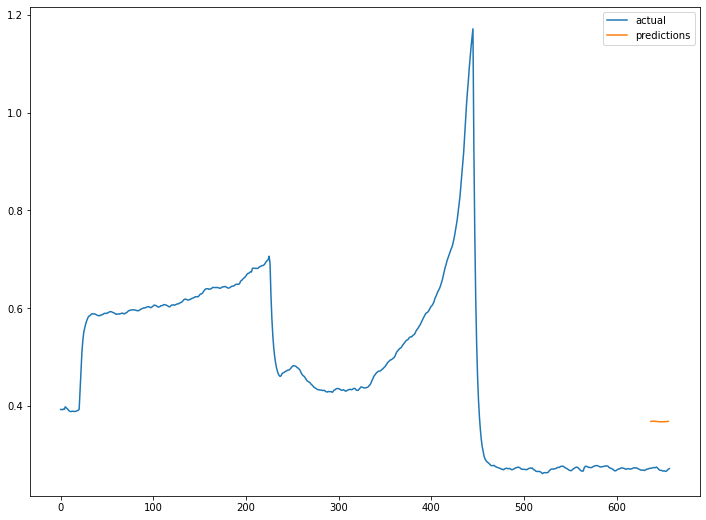

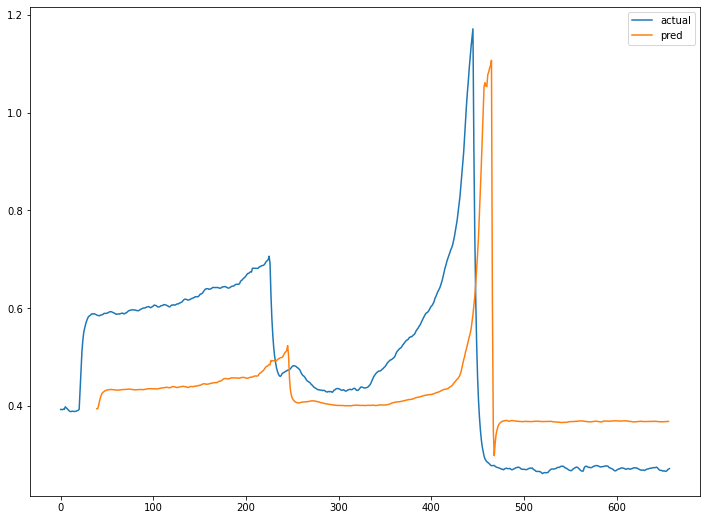

num 0 [36.3206816] actual [0.26958372] prediction [0.36749837]
오차율 : [36.3206816]
num 1 [37.30312239] actual [0.26780509] prediction [0.36770475]
오차율 : [37.30312239]
num 2 [38.0185749] actual [0.26650696] prediction [0.3678291]
오차율 : [38.0185749]
num 3 [38.10494628] actual [0.26637] prediction [0.36787015]
오차율 : [38.10494628]
num 4 [37.41451825] actual [0.26762083] prediction [0.36774987]
오차율 : [37.41451825]
num 5 [36.82657004] actual [0.26880389] prediction [0.36779514]
오차율 : [36.82657004]
num 6 [36.02372074] actual [0.27020765] prediction [0.3675465]
오차율 : [36.02372074]
num 7 [35.97000094] actual [0.27015155] prediction [0.36732507]
오차율 : [35.97000094]
num 8 [35.38667832] actual [0.27119123] prediction [0.3671568]
오차율 : [35.38667832]
num 9 [34.65664724] actual [0.27249035] prediction [0.36692637]
오차율 : [34.65664724]
num 10 [34.70752367] actual [0.27235788] prediction [0.36688656]
오차율 : [34.70752367]
num 11 [34.8644653] actual [0.27199104] prediction [0.36681926]
오차율 : [34.8644653]
nu

In [58]:
df=pd.read_csv('m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
df=df[df['CellNo']==20].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, 20)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[39:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)